# Intro to Gym/Gymnasium
In this demo, we will explore a reinforcement learning agent training platform OpenAI Gym and Farama Foundation Gymnasium.      
You can see documentation and more info here: https://gymnasium.farama.org/     
You can see their source code and mode details how it works in their git: https://github.com/openai/gym and https://github.com/Farama-Foundation/Gymnasium   
Extending the collections that gym already has, OpenAI Universe https://github.com/openai/universe (deprecated as of now; April 2020) or Retro https://github.com/openai/retro provides a platform with which you can convert existing games to Gymnasium/Gym environment.
Note that the development of tools in reinforcement learning is happening very rapidly and things are mostly experimental that it's uncommon that certain packages get updated without backward compatibilty in a matter of a few months to a year. 

Currently, this demo uses gymnasium version 0.28.1 or gym version 0.26.1.

## High-level overview

Gym has been deveoped and maintained by OpenAI (Gymnasium is a fork of OpenAI's Gym library since OpenAI handed over maintenance a few years ago to an outside team, and is where future maintenance will occur going forward). `gym` and `gymnasium` provides a rich collection of environments for reinforcement learning experiments in an unified interface. Although each environment may look differently and can do different things, the main structure of a gym envoronment includes    

- Action space: set of actions either discrete or continuous, or both.
- Observation space: a boundary within an agent can be.
- `step` method: executes an action and returns reward and whether it's terminal state.
- `reset` method: initializes the environment.    

These core functions are in cluded in the class `Env` defined in https://github.com/openai/gym/blob/master/gym/core.py
Note that the actual detailed implementation of what values to return (e.g in `step` method) is defined in the each environment, and the `Env` class in `core.py` defines the overall structure.

Environment has a few [environment groups](https://gymnasium.farama.org/content/basic_usage/) that ships with standard gym package, and it also has 3rd party environments as well as lets you to build your own.
Among its many environments, we will use a basic environment called "Classic control" in this demo.


In [1]:
import gymnasium as gym
# You can choose to use gym library instead of gymnasium
# import gym 

import warnings
from collections import namedtuple
warnings.filterwarnings("ignore", category=DeprecationWarning)
partition = namedtuple("partition", ["type", "subtype"])

In [2]:
gym.__version__

'1.1.1'

In [3]:
e = gym.make('CartPole-v1') 

In [4]:
obs = e.reset()

In [5]:
obs

(array([-0.02072543, -0.01905872,  0.01790823,  0.0327855 ], dtype=float32),
 {})

In [6]:
e.action_space #means possible actions are left and right
#the action space is defined in gym.spaces

Discrete(2)

In [7]:
from gym.spaces.discrete import Discrete

In [8]:
d = Discrete(2) #the Discrete is a class that has methods .sample and .contains

In [9]:
[d.sample() for x in range(10)] #sample generates an action output

[1, 0, 1, 0, 1, 0, 1, 0, 1, 1]

In [10]:
print(d.contains(0), d.contains(2)) #with .contains method, you can check whether an integer is a valid action

True False


In [11]:
e.observation_space #returns Box class, which represents n-dim tensor

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

In [12]:
e.step(1)

(array([-0.0211066 ,  0.1758019 ,  0.01856394, -0.2541938 ], dtype=float32),
 1.0,
 False,
 False,
 {})

In [13]:
e.step(0) 
# see https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
# force = self.force_mag if action==1 else -self.force_mag

(array([-0.01759056, -0.01958013,  0.01348006,  0.0442862 ], dtype=float32),
 1.0,
 False,
 False,
 {})

## Making an agent
Since the `gym` provides us the environment, it's our job to make an agent (policy) that can interact with the environemnt. Here is an example of a random agent.

In [14]:
import gymnasium as gym

env = gym.make("CartPole-v1")

total_reward = 0.0
total_steps = 0
obs = env.reset()

while True:
    action = env.action_space.sample() #.sample method gives a random action sample
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    if done:
        break

print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))

Episode done in 13 steps, total reward 13.00


## Monitoring the agent

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [16]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title("%s | Step: %d %s" % (env.spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

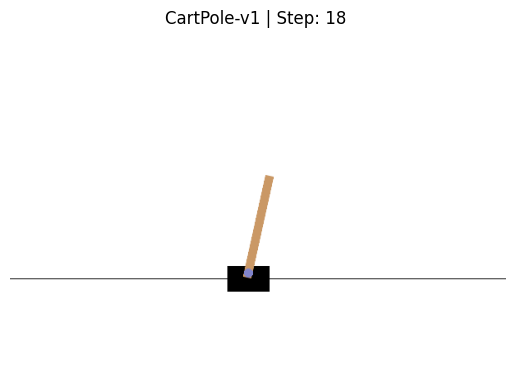

Episode done in 18 steps, total reward 18.00


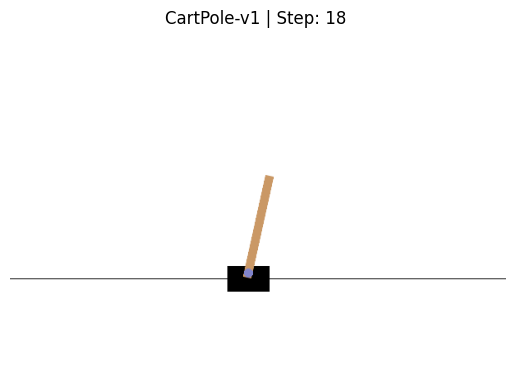

In [17]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
#env = gym.wrappers.Monitor(env, "recording", force=True)

total_reward = 0.0
total_steps = 0
obs = env.reset()

while True:
    action = env.action_space.sample()
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    show_state(env,total_steps)
    if done:
        break

print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))
env.close()
env.env.close()

## Environment wrappers
`Env` offers a `Wrapper` class that allow you to modify settings in the `Env` class. `Wrapper` has three subclasses `RewardWrapper`, `ObservationWrapper` and `ActionWrapper`.
Let's take an example of an agent that takes a random action e.g. 10% of the time. We'll write a class that overrides `Env`'s action usging `ActionWrapper`. 

In [18]:
import gymnasium as gym
import random

class RandomEpsilonWrapper(gym.ActionWrapper):
    def __init__(self, env, epsilon=0.1):
        super(RandomEpsilonWrapper, self).__init__(env)
        self.epsilon = epsilon

    def action(self, action):
        if random.random() < self.epsilon:
            print("Random!")
            return self.env.action_space.sample()
        else:
            print("Policy")
        return action

In [19]:
env = RandomEpsilonWrapper(gym.make("CartPole-v1"),epsilon=0.5)

obs = env.reset()
total_reward = 0.0

while True:
    obs, reward, done, _, _= env.step(0) #we have a fixed policy of going to left (action = 0) only
    total_reward += reward
    #show_state(env) #with this line uncommented, you can also monitor
    if done:
        break

print("Reward got: %.2f" % total_reward)

Random!
Policy
Policy
Policy
Random!
Random!
Policy
Random!
Policy
Policy
Random!
Random!
Policy
Policy
Policy
Reward got: 15.00


## Implementing simple  reflex agent
Below is the rule defined in the [Cartpole environment](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)
```
   Observation: 
        Type: Box(4)
        Num	Observation                 Min         Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf
        
    Actions:
        Type: Discrete(2)
        Num	Action
        0	Push cart to the left
        1	Push cart to the right
        
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display)
        Episode length is greater than 200
        Solved Requirements
        Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.
```

Let's make an agent that act deterministically. Let's say the agent can sense the velocity of the cart vc and the velocity of the pole vp. It will continue going to the same direction until it senses the pole starts falling toward the oposite direction of it moving (Simple reflex agent).

Here, we create an Agent class first, which runs single episode and can run episodes n times so that we can do some stats. Then we'll create subclasses using inheritance (below examples do not use `super` as we used in the wrapper example above)

In [23]:
# deterministic rule
# first choose random action
# monitor vc and vp while keep going to the same direction
# if the sign of the two velocities are different, flip the direction (action)
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Agent:
    def __init__(self):
        self.env = gym.make("CartPole-v1")
        self.state = self.env.reset()
        self.rewards = []
        self.steps = []
        self.poilcy = []
        
    def select_action(self, state, action):  
        return action

    def play_episode(self, env):
        total_reward = 0.0
        state = env.reset()
        action = random.choice([0,1])
        steps = 0
        actions = []
        isInit = 1
        while True:
            if isInit:
                state = state[0]
                isInit = 0
            action = self.select_action(state, action)
            new_state, reward, is_done, _, _ = env.step(action)
            total_reward += reward
            steps +=1
            actions.append(action)
            if is_done:
                break
            state = new_state
        return total_reward, steps, actions
    
    def repeat(self,n_sample):
        rewards =[]
        steps=[]
        policy = []
        for i in range(n_sample):
            reward, step, actions = self.play_episode(self.env)
            rewards.append(reward)
            steps.append(step)
            policy.append(actions)
        self.rewards = rewards
        self.steps = steps
        # self.policy = np.array(policy)
        self.policy = policy
        
        
class ReflexAgent(Agent):       
    def select_action(self, state, action):  
        if state[1]*state[3]<0:
            action = int(1-action)  
        return action    


47.816 21.60217914933584 221.0


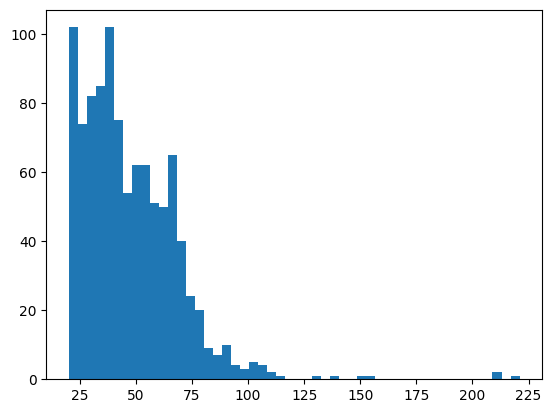

In [24]:
ra = ReflexAgent()
ra.repeat(1000)
rewards = ra.rewards
plt.hist(rewards,bins=50)
print(np.mean(rewards), np.std(rewards), max(rewards))

In [25]:
class RandomAgent(Agent):       
    def select_action(self,state,action):  
        return random.choice([0,1]) 

21.75 11.627875988330802 97.0


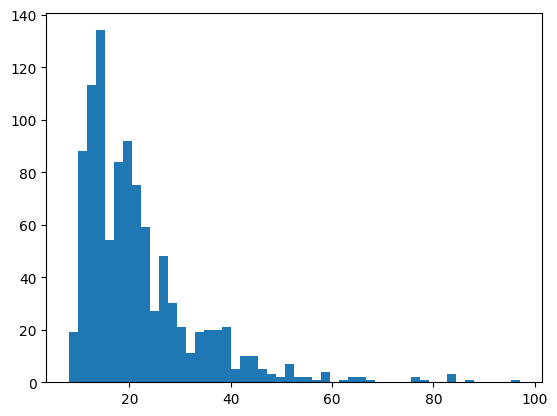

In [26]:
rda= RandomAgent()
rda.repeat(1000)
rewards1 = rda.rewards
plt.hist(rewards1,bins=50)
print(np.mean(rewards1), np.std(rewards1), max(rewards1))

In [27]:
def replay(policy):
    env = gym.make("CartPole-v1", render_mode='rgb_array')
    obs = env.reset()
    step = 0
    for a in policy:
        env.step(a)
        show_state(env, step)
        step+=1

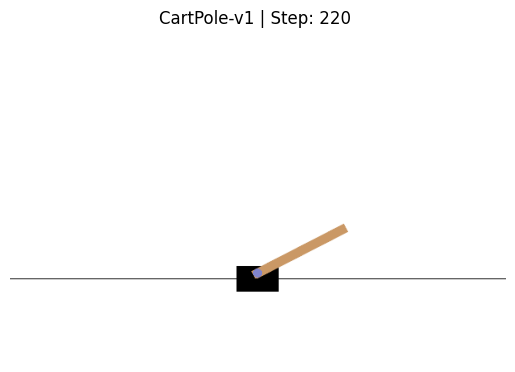

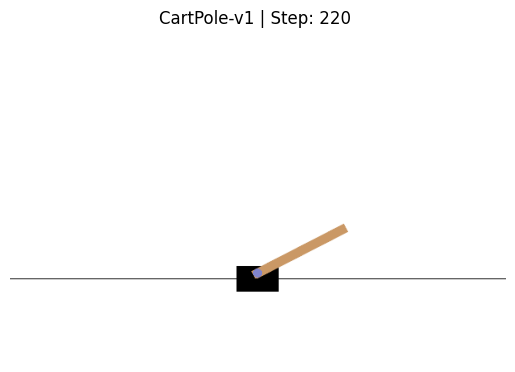

In [28]:
best_reflex = ra.policy[np.argmax(rewards)]
replay(best_reflex) 
# Is this a bug?? It didn't terminate; 
# it's because everytime the environment is reset, the initial state is different that the policy is not the best for that episode.
# To make it a proper reply you'll need to also save the initial state, or return the entire env object to reproduce the result.
# The goal of your algorithm is that no matter which initial state it started with, it behaves optimally.

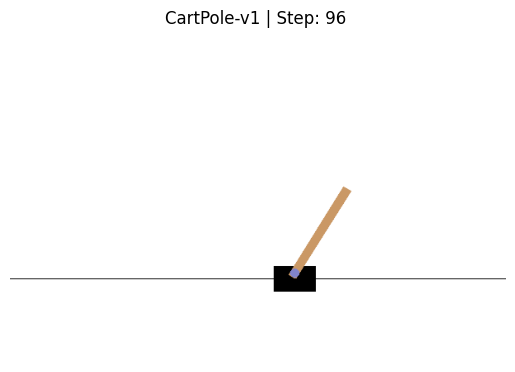

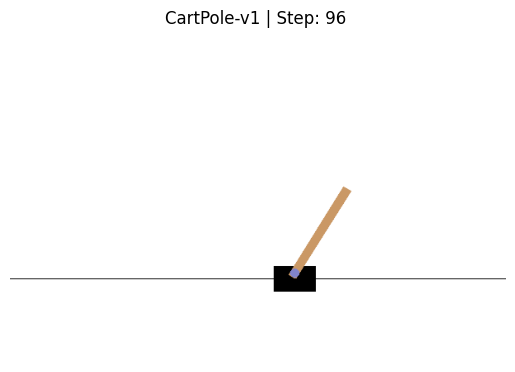

In [29]:
best_random = rda.policy[np.argmax(rewards1)]
replay(best_random) 